# <center>Option Pricing Models</center>
### Kirill Zakharov
2022

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from functools import partial
from scipy.optimize import minimize, fsolve
import tqdm

%matplotlib inline

plt.style.use('ggplot')

In [395]:
class StochasticProcesses:
    def __init__(self, option_type='call'):
        self.option_type = option_type
        
    def geometric_BM(self, T, s0, mu, sigma, n):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.log(s0)
        dt = T/float(n)
        
        for t in range(n):
            x[t+1] = x[t] + (mu - (sigma**2)/2) * dt + sigma * np.sqrt(dt) * stats.norm.rvs(loc=0, scale=1)
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return time, s
    
    def poisson_process(self, T, s0, xiP, n, type_p='ordinary'):
        time = np.zeros(n + 1)
        dt = T/float(n)
        poisson_distr = np.random.poisson(xiP * dt, n + 1)
        
        if type_p == 'ordinary':
            x = np.zeros(n + 1)
            x[0] = s0
            
            for t in range(n):
                x[t+1] = x[t] + poisson_distr[t]
                time[t+1] = time[t] + dt
                
            return time, x
            
        elif type_p == 'compensated':     
            xc = np.zeros(n + 1)
            xc[0] = s0
            
            for t in range(n):
                xc[t+1] = xc[t] + poisson_distr[t] - xiP * dt
                time[t+1] = time[t] + dt
            
            return time, xc
        else:
            print('Wrong type process, available: ordinary and compensated')
            
    def merton_process(self, T, s0, xiP, muj, sigmaj, r, sigma, n):
        time = np.zeros(n + 1)
        dt = T/float(n)
        
        z = np.random.normal(0.0, 1.0, n + 1)
        zj = np.random.normal(muj, sigmaj, n + 1)
        poisson_distr = np.random.poisson(xiP * dt, n + 1)
        
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        
        s[0] = s0
        x[0] = np.log(s0)
        
        EeJ = np.exp(muj + 0.5 * sigmaj**2)
        
        for t in range(n):
            x[t+1] = x[t] + (r - xiP * (EeJ - 1) - 0.5 * sigma**2) * dt +\
                sigma * np.sqrt(dt) * z[t] + zj[t] * poisson_distr[t]
            
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return time, s
    
    
       
        
    
    def plot_path(self, time, s, label='Process path', title='Process Visualization'):
        plt.subplots(figsize=(10, 5), dpi=100)
        plt.plot(time, s, label=label)
        
        plt.title(title, fontsize=16)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Values', fontsize=14)
        plt.legend()
        plt.show()

In [396]:
process = StochasticProcesses()

In [256]:
T = 10
s0 = 1
r = 0.05
sigma = 0.15
n = 1000

## Geometric Brownian Motion

In [426]:
gbm = process.geometric_BM(T, s0, r, sigma, n)

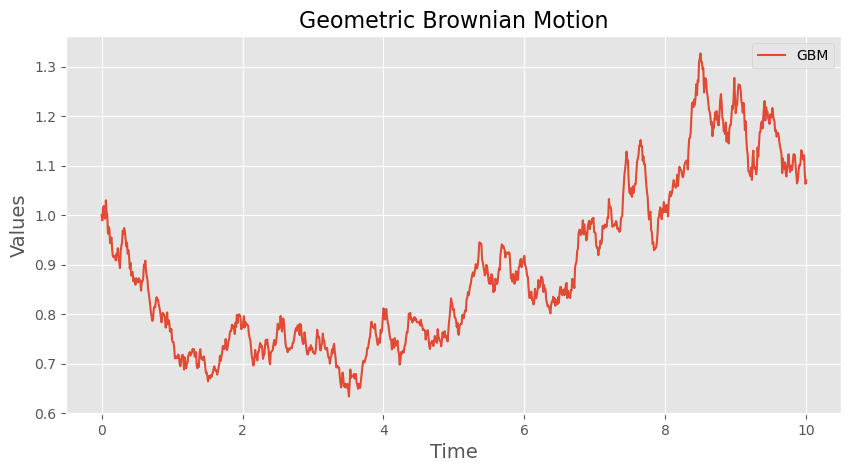

In [427]:
process.plot_path(gbm[0], gbm[1], 'GBM', 'Geometric Brownian Motion')

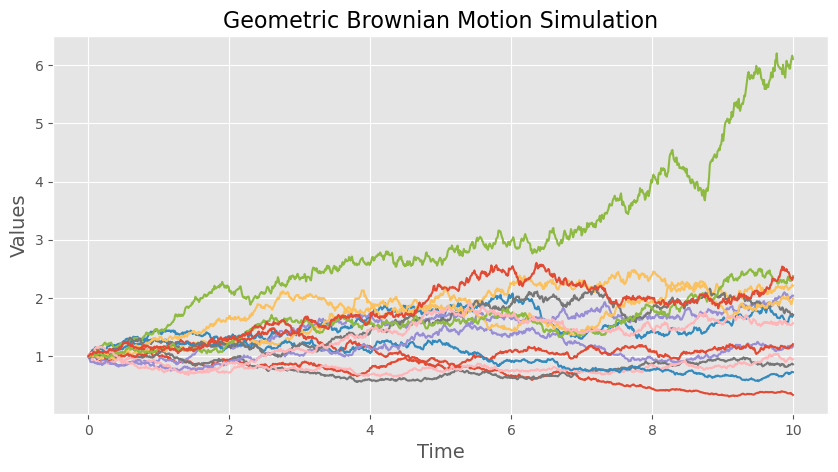

In [259]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(15):
    
    gbm = process.geometric_BM(T, s0, r, sigma, n)

    plt.plot(gbm[0], gbm[1])
        
    plt.title('Geometric Brownian Motion Simulation', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)

## Poisson Process

In [371]:
xiP = 1
T = 50
s0 = 1
n = 50

In [372]:
poisson = process.poisson_process(T, s0, xiP, n, 'ordinary')

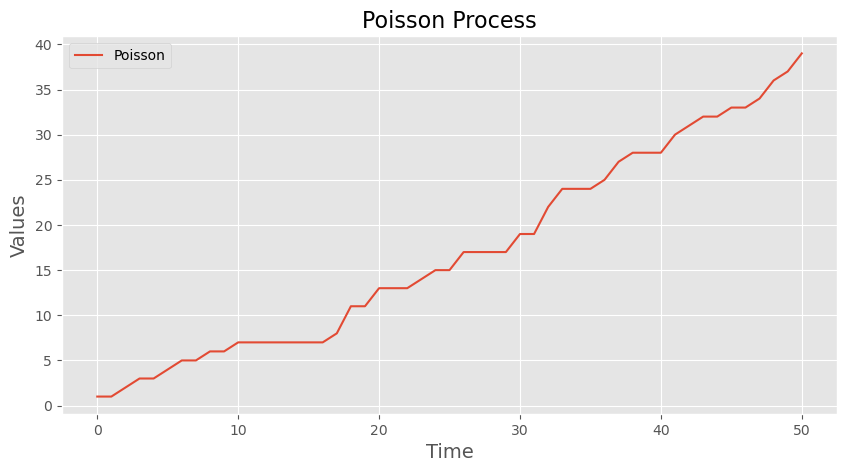

In [373]:
process.plot_path(poisson[0], poisson[1], 'Poisson', 'Poisson Process')

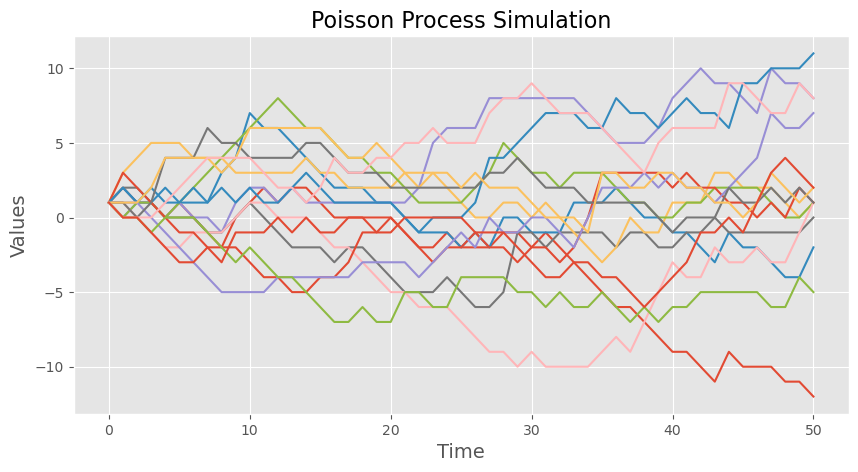

In [375]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(15):
    
    gbm = process.poisson_process(T, s0, xiP, n, 'compensated')

    plt.plot(gbm[0], gbm[1])
        
    plt.title('Poisson Process Simulation', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)

## Merton Process

In [385]:
T = 10
s0 = 1
r = 0.05
sigma = 0.15
n = 1000
xiP = 1
muj = 0
sigmaj = 0.2

In [386]:
merton_process = process.merton_process(T, s0, xiP, muj, sigmaj, r, sigma, n)

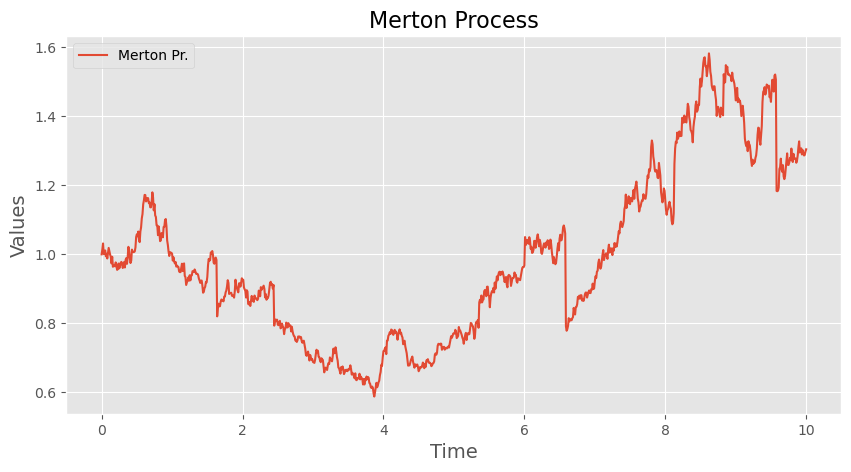

In [387]:
process.plot_path(merton_process[0], merton_process[1], 'Merton Pr.', 'Merton Process')

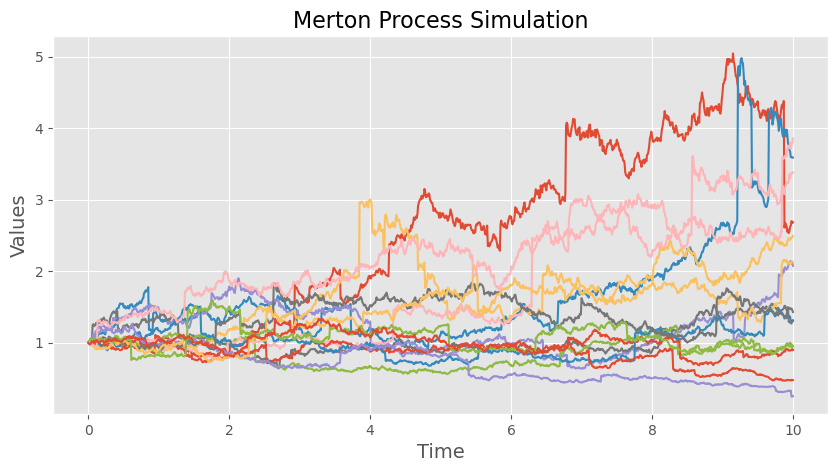

In [392]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(15):
    
    gbm = process.merton_process(T, s0, xiP, muj, sigmaj, r, sigma, n)

    plt.plot(gbm[0], gbm[1])
        
    plt.title('Merton Process Simulation', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)

In [423]:
def black_scholes(s, r, sigma, strike, option_type='call', maturity=10, t=1):
        if option_type == 'call':
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = s * stats.norm.cdf(d1, loc=0, scale=1) - strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(d2, loc=0, scale=1)
        
        elif option_type == 'put':       
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(-d2, loc=0, scale=1) - s * stats.norm.cdf(-d1, loc=0, scale=1)
            
        else:
            print('Incorrect type, available: call and put')
        
        return c

In [621]:
T = 10
s0 = 100
strike = 120
r = 0.05
n = 50
sigma = 0.2
gbm = process.geometric_BM(T, s0, r, sigma, n)
strikes = gbm[1] + 10

In [622]:
black_scholes(s0, r, sigma, strike, 'call', T, 2)

31.296534713866166

In [623]:
bs_options = []
for i in range(T):
    bs_options.append(black_scholes(gbm[1][i], r, sigma, strikes[i], 'call', T, i))

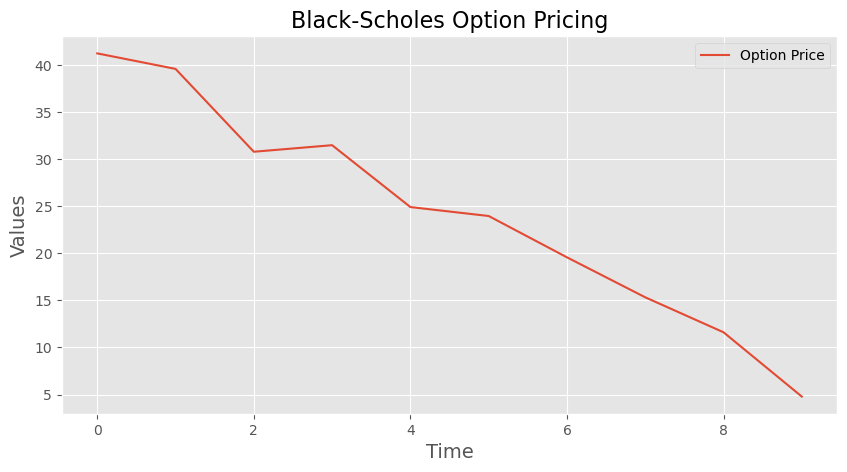

In [624]:
plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(bs_options, label='Option Price')
        
plt.title('Black-Scholes Option Pricing', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()